In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
contfeatureslist=[]
for colname, x in train.iloc[1,:].iteritems():
    if(not str(x).isalpha()):
        contfeatureslist.append(colname)

In [4]:
contfeatureslist

['id',
 'cont1',
 'cont2',
 'cont3',
 'cont4',
 'cont5',
 'cont6',
 'cont7',
 'cont8',
 'cont9',
 'cont10',
 'cont11',
 'cont12',
 'cont13',
 'cont14',
 'loss']

In [5]:
contfeatureslist.remove("id")
contfeatureslist.remove("loss")
contfeatureslist

['cont1',
 'cont2',
 'cont3',
 'cont4',
 'cont5',
 'cont6',
 'cont7',
 'cont8',
 'cont9',
 'cont10',
 'cont11',
 'cont12',
 'cont13',
 'cont14']

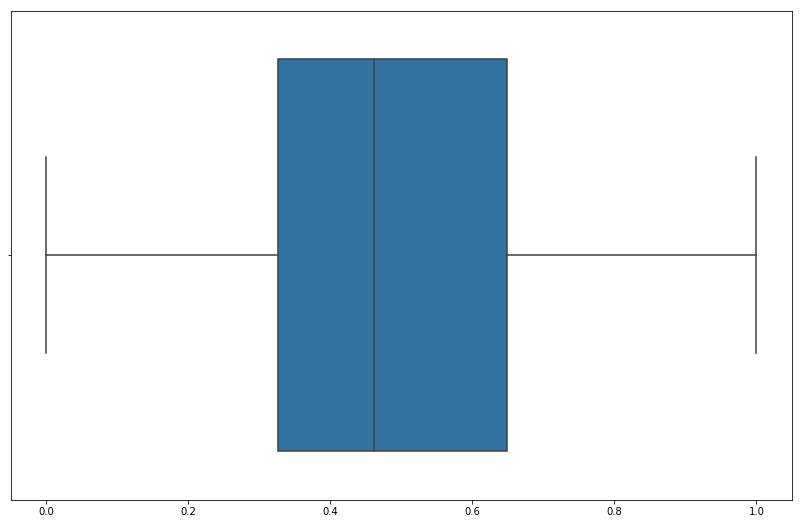

In [6]:
import seaborn as sns
plt.figure(figsize=(14,9))
sns.boxplot(train[contfeatureslist])

In [7]:
contfeatureslist.append("loss")

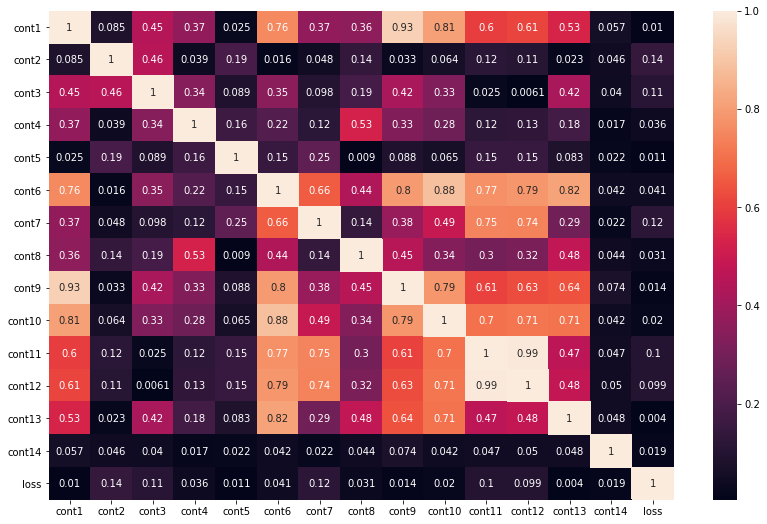

In [9]:
correlationmatrix=train[contfeatureslist].corr().abs()
plt.subplots(figsize=(14,9))
sns.heatmap(correlationmatrix, annot=True)
#
sns.heatmap(correlationmatrix, mask= correlationmatrix<1,cbar=False)
plt.show()

id       -0.002155
cont1     0.516424
cont2    -0.310941
cont3    -0.010002
cont4     0.416096
cont5     0.681622
cont6     0.461214
cont7     0.826053
cont8     0.676634
cont9     1.072429
cont10    0.355001
cont11    0.280821
cont12    0.291992
cont13    0.380742
cont14    0.248674
loss      3.794958
dtype: float64

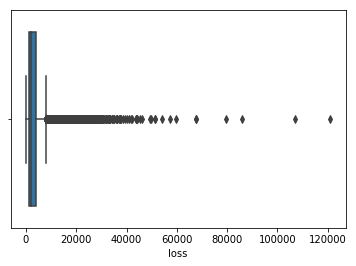

In [11]:
sns.boxplot(train["loss"])
train.skew()

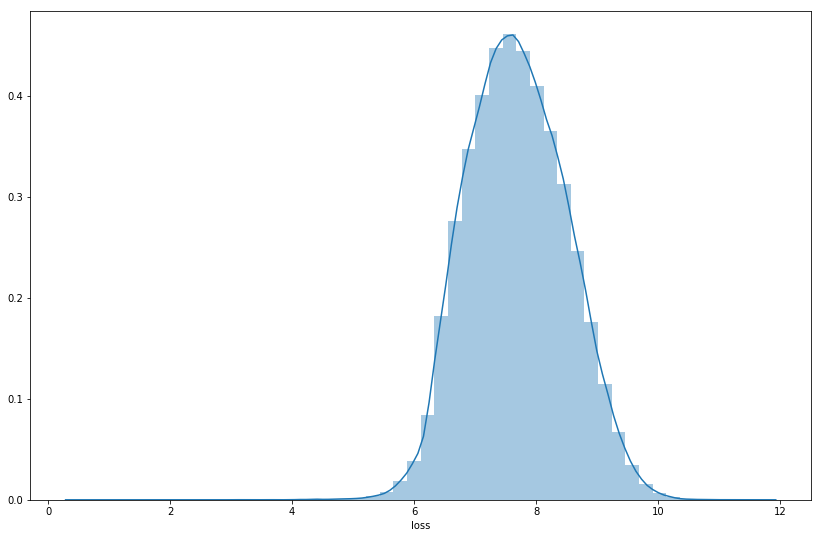

In [12]:
plt.figure(figsize=(14,9))
sns.distplot(np.log1p(train["loss"]))

So we got normal distribution by applying logarithm on loss function Finally we got normal distribution, so we can train model using target feature as log of loss. This way we don't have to remove outliers.

In [13]:
catcount=sum(str(x).isalpha() for x in train.iloc[1,:])
catcount

116

In [15]:
catfeatureslist=[]
for colname, x in train.iloc[1,:].iteritems():
    if(str(x).isalpha()):
        catfeatureslist.append(colname)

In [17]:
from sklearn.preprocessing import LabelEncoder
for cf1 in catfeatureslist:
    le=LabelEncoder()
    le.fit(train[cf1].unique())
    train[cf1]=le.transform(train[cf1])

In [18]:
train.head(5)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,0,1,0,1,0,0,0,0,1,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,0,1,0,0,0,0,0,0,1,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,0,1,0,0,1,0,0,0,1,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,1,1,0,1,0,0,0,0,1,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,0,1,0,1,0,0,0,0,1,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [20]:
for cf1 in catfeatureslist:
    le = LabelEncoder()
    le.fit(test[cf1].unique())
    test[cf1] = le.transform(test[cf1])

In [23]:
train.shape

(188318, 132)

In [26]:
train1=train.iloc[0:8000,:]
test1= test.iloc[0:5000,:]
x_train = train1.drop("loss",axis=1).as_matrix()
y = np.log(train1["loss"]).as_matrix()
x_test = test1.as_matrix()
#submission=pd.read_csv('submission.csv')

C:\Users\v9022828\AppData\Local\conda\conda\envs\Imagebox\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\v9022828\AppData\Local\conda\conda\envs\Imagebox\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\v9022828\AppData\Local\conda\conda\envs\Imagebox\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [31]:
from keras.layers import Dense, Dropout, Activation
from keras.layers.advanced_activations import PReLU
from keras.models import Sequential

def nn_model(x_train_):
    model = Sequential()
    # as first layer in a sequential model:
    #Initializations define the way to set the initial random weights of Keras layers
    model.add(Dense(400, input_dim = x_train_.shape[1], init = 'he_normal'))
    model.add(PReLU())
    model.add(Dropout(0.4))
    # after the first layer, you don't need to specify the size of the input anymore:
    model.add(Dense(200, init = 'he_normal'))
    model.add(PReLU())
    model.add(Dropout(0.2))
    model.add(Dense(1, init = 'he_normal'))
    model.compile(loss = 'mae', optimizer = 'adadelta')
    return(model)

In [32]:
model=nn_model(x_train)
n_epochs = 25
fit = model.fit(x_train,y, nb_epoch = n_epochs,batch_size=250,verbose = 1)
pred = model.predict(x_test,verbose=1)

C:\Users\v9022828\AppData\Local\conda\conda\envs\Imagebox\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, input_dim=131, kernel_initializer="he_normal")`
  if __name__ == '__main__':
C:\Users\v9022828\AppData\Local\conda\conda\envs\Imagebox\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, kernel_initializer="he_normal")`
  del sys.path[0]
C:\Users\v9022828\AppData\Local\conda\conda\envs\Imagebox\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_normal")`
  app.launch_new_instance()
C:\Users\v9022828\AppData\Local\conda\conda\envs\Imagebox\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/25
8000/8000 [==============================] - 1s 171us/step - loss: 1315.6332
Epoch 2/25
8000/8000 [==============================] - 1s 65us/step - loss: 602.1339
Epoch 3/25
8000/8000 [==============================] - 0s 61us/step - loss: 315.6423
Epoch 4/25
8000/8000 [==============================] - 1s 66us/step - loss: 191.3784
Epoch 5/25
8000/8000 [==============================] - 1s 73us/step - loss: 169.7067
Epoch 6/25
8000/8000 [==============================] - 1s 67us/step - loss: 148.5792
Epoch 7/25
8000/8000 [==============================] - 1s 63us/step - loss: 125.2063
Epoch 8/25
8000/8000 [==============================] - 0s 59us/step - loss: 105.4252
Epoch 9/25
8000/8000 [==============================] - 0s 58us/step - loss: 82.7241
Epoch 10/25
8000/8000 [==============================] - 0s 60us/step - loss: 64.5407
Epoch 11/25
8000/8000 [==============================] - 1s 63us/step - loss: 50.3336
Epoch 12/25
8000/8000 [==============================

In [33]:
import os
def write_submission_file(predictions,name):
    if not os.path.exists("results"):
        os.makedirs("results")
        submission.iloc[:, 0]= test.iloc[:,0]
    submission.iloc[:,1] = predictions
    submission.to_csv('results/' + name + '.csv', index=None)

In [37]:
submission=pd.read_csv('submission.csv',delimiter="\t")
write_submission_file(np.exp(pred),"keras_nn")


EmptyDataError: No columns to parse from file

In [39]:
ID = test['id']

with open("submission.csv", "w") as subfile:
    subfile.write("id,loss\n")
    for i, pred in enumerate(list(pred)):
        subfile.write("%s,%s\n"%(ID[i],pred))

In [41]:
from sklearn.cross_validation import KFold
nfolds = 5
folds = KFold(len(y), n_folds = nfolds, shuffle = True, random_state = 20)

ModuleNotFoundError: No module named 'sklearn.cross_validation'